In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#주제: 다음 분기에 어떤 게임을 설계해야 할까?

# 분석 방향성: 지역별, 연도별 트렌드의 변화를 확인하고 지속적인 인기가 있는 장르의 ip를 활용해 다음 게임을 준비하는 방향으로 분석을 진행합니다.

In [55]:
#뒤에 사용하게 될 라이브러리 미리 입력 
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib as mpl
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = [10, 6]

mpl.rc("font", family='Malgun Gothic')
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

#데이터셋 불러오기

구글 드라이브에 담겨있는 csv 파일을 불러와 데이터셋을 만듭니다.

In [56]:
#데이터셋 불러오기
data_url = "/content/gdrive/MyDrive/Data/vgames2.csv"

df = pd.read_csv(data_url)
#데이터 프레임 출력
df

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...,...
16593,16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


Name : 게임의 이름입니다.

Platform : 게임이 지원되는 플랫폼의 이름입니다.

Year : 게임이 출시된 연도입니다.

Genre : 게임의 장르입니다.

Publisher : 게임을 제작한 회사입니다.

NA_Sales : 북미지역에서의 출고량입니다.

EU_Sales : 유럽지역에서의 출고량입니다.

JP_Sales : 일본지역에서의 출고량입니다.

Other_Sales : 기타지역에서의 출고량입니다.

In [57]:
del df['Unnamed: 0'] #불필요한 column 제거

df.duplicated(keep='first') # 중복된 내용이 있을시 첫번째만 남기고 제거

0        False
1        False
2        False
3        False
4        False
         ...  
16593    False
16594    False
16595    False
16596    False
16597    False
Length: 16598, dtype: bool

In [58]:
df.shape # 중복된 row 사라졌는지 체크

(16598, 9)

In [59]:
#결측치 확인

df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

##결측데이터 
연도상 미표기 271건\
장르 미표기 50건\
퍼블리셔 미표기 58건\
확인됨.

In [60]:
#데이터 타입 확인
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

int로 표기되어야할 Year와 float로 표기되어야할 Sales들의 타입이 이상한점 발견됨.

In [61]:
df['EU_Sales'].astype(float)
#Sales 셀 안에 문자가 포함된것이 확인됨. ValueError: could not convert string to float: '0.33M'

ValueError: ignored

In [62]:
df['EU_Sales'].unique()

array(['0', '0.09', '0.01', '0.03', '0.33M', '0.05', '0.02', '0.16',
       '0.45', '0.04', '0.53', '0.23', '0.1', '0.34', '0.22', '0.2',
       '0.03M', '0.33', '0.08', '0.26', '0.07', '0.11', '0.17', '0.06',
       '0.14', '0.12', '0.24', '0.13', '0.21', '0.15', '0.3', '2.38',
       '0.55', '0K', '1.12', '0.43', '50K', '0.63', '0.35', '1.11',
       '0.41', '0.01M', '0.89', '3.15', '0.18', '0.54', '0.25', '0.29',
       '0.61', '0.27', '0.86', '0.87', '0.32', '0.44', '2.48', '0.48',
       '0.47', '0.66', '0.76', '0.27M', '0.15M', '1.94', '0.97', '0.72',
       '620K', '0.49', '5.36', '0.31', '0.62', '0.4', '0.57', '0.46',
       '1.97', '1.02', '1.75', '0.28', '2.46', '0.38', '0.5', '0.9',
       '0.19', '0.39', '0.67', '0.64', '0.37', '0.51', '2.83', '0.59',
       '0.75', '0.52', '1.34', '760K', '80K', '5.09', '1.09', '2.19',
       '2.17', '0.91', '2.26', '0.83', '0.74', '0.88', '0.77', '1.24',
       '0.92', '0.8', '0.36', '20K', '1.15', '0.58', '1.51', '0M', '40K',
       '1.1

M,K와 같은 단위가 표기된것으로 확인됨.
#Sales안에 단위 수정 및 연도 표기 변경

In [65]:
# Sales 에서 M,K 단위 변경 및 object->float 변경
def sales(x):   #두번이상 런타임시 에러 발생함.
  if x[-1] == 'M':
    return x[:-1]*1
  elif x[-1] == 'K':
    return float(x[:-1])/1000
  return x

df['NA_Sales'] = df['NA_Sales'].apply(sales).astype(float)
df['EU_Sales'] = df['EU_Sales'].apply(sales).astype(float)
df['JP_Sales'] = df['JP_Sales'].apply(sales).astype(float)
df['Other_Sales'] = df['Other_Sales'].apply(sales).astype(float)

#결측치 제거
df = df.dropna(axis = 0, how = 'any')  # 공란은 우선 삭제적으로 삭제함.

# Year의 float -> int로 변경
df['Year'] = df['Year'].astype(int)

In [66]:
# 연도상 오류 수정하기
# 1~21사이 연도는 2000더해주고 22~99사이 숫자는 1900더해주기.

def fix_century(x):
    if x >= 0 and x < 21:
      x = x + 2000 
    elif x >= 21 and x <100:
      x = x + 1900
    return x
    
df['Year'] = df['Year'].apply(fix_century)

In [67]:
# 지역 출고량 합산 column 생성

df['Total_Sales'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']

In [71]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


# 지역과 연도별로 게임 트렌드가 있을까?

In [73]:
# 최근 5년간의 데이터 2015~2020년 사이의 데이터 정리
df2= df.loc[(df.Year >=2015)&(df.Year <= 2020)]
df2.shape

(957, 10)

In [74]:
# 2010~2015년 사이의 데이터 정리
df3= df.loc[(df.Year >=2010)&(df.Year <= 2015)]
df3.shape

(4774, 10)

##데이터 양으로 보아 2015~2020사이의 값은 데이터가 충분하지 않은 것으로 보여짐.

In [75]:
# 2000~2020년 사이의 데이터로 정리
df= df.loc[(df.Year >=2000)&(df.Year <= 2020)]
df.shape

(14273, 10)

#1.지역에 따라서 선호하는 게임 장르가 다를까?

In [76]:
# 지역별 선호 게임 확인하기

# 연도, 지역별 장르 
df_G = pd.DataFrame(df.groupby(['Year','Genre']).sum()).reset_index()

#지역별 연도 합산 분류 
df_Y = df_G.groupby('Year').sum().reset_index()

df_G2 = df_G.iloc[:,:-1] #melt 전에 total 제외
df_G2

,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,2000,Action,17.72,10.82,3.74,1.61
1,2000,Adventure,1.01,0.69,1.11,0.15
2,2000,Fighting,9.69,6.31,3.05,1.21
3,2000,Misc,7.14,4.91,2.77,0.73
4,2000,Platform,7.87,4.64,2.56,0.98
...,...,...,...,...,...,...
201,2016,Sports,4.57,7.36,0.78,1.92
202,2016,Strategy,0.11,0.32,0.05,0.04
203,2017,Action,0.00,0.00,0.01,0.00
204,2017,Role-Playing,0.00,0.00,0.04,0.00


#지역별 선호 장르

In [77]:
#지역별 출고량 시각화를 위해 지역과 출고량값을 시각화하기 편하게 데이터프레임 변경.
#data Tidy화
id_vars = ["Year","Genre"] #Year와 Genre를 기준으로 삼기.

df_tidy = pd.melt(df_G2,id_vars=id_vars ,var_name = "location",\
                  value_name="Sales") #melt를 이용하여 location과 Sales를 새로운 column으로 삼아 데이터 변경
#출력
df_tidy 

,Year,Genre,location,Sales
0,2000,Action,NA_Sales,17.72
1,2000,Adventure,NA_Sales,1.01
2,2000,Fighting,NA_Sales,9.69
3,2000,Misc,NA_Sales,7.14
4,2000,Platform,NA_Sales,7.87
...,...,...,...,...
819,2016,Sports,Other_Sales,1.92
820,2016,Strategy,Other_Sales,0.04
821,2017,Action,Other_Sales,0.00
822,2017,Role-Playing,Other_Sales,0.00


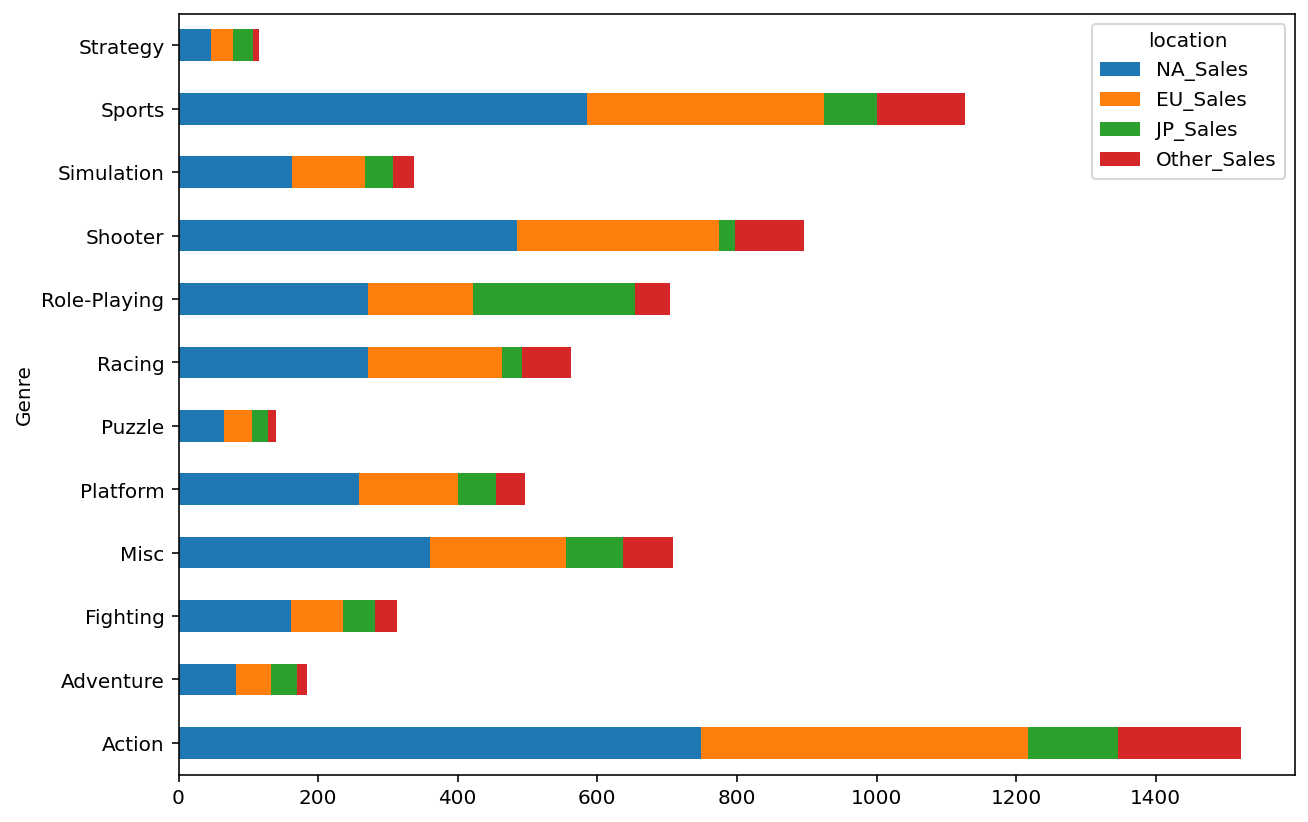

In [78]:
#지역별 선호 장르 시각화
df_tidy = pd.melt(df_G2.iloc[:,1:],id_vars="Genre" ,var_name = "location", value_name="Sales")
df_T = df_tidy.groupby(['Genre','location']).sum().reset_index()  #합산

#pivot화 진행
df_P = df_T.pivot(index = 'Genre',columns = 'location', values = 'Sales') #groupby 사용이후 stacked plot 적용이 안되서 plot으로 사용해봄...
df_P.loc[:,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].plot.barh(stacked=True, figsize=(10,7))

##지역별 선호 장르

NA,EU,Other - Action, Sports, Shooter

JP - Role-Playing, Action, sports


출고량은 Action, Sports, Shooter 순으로 높음.

#2.연도별 선호장르


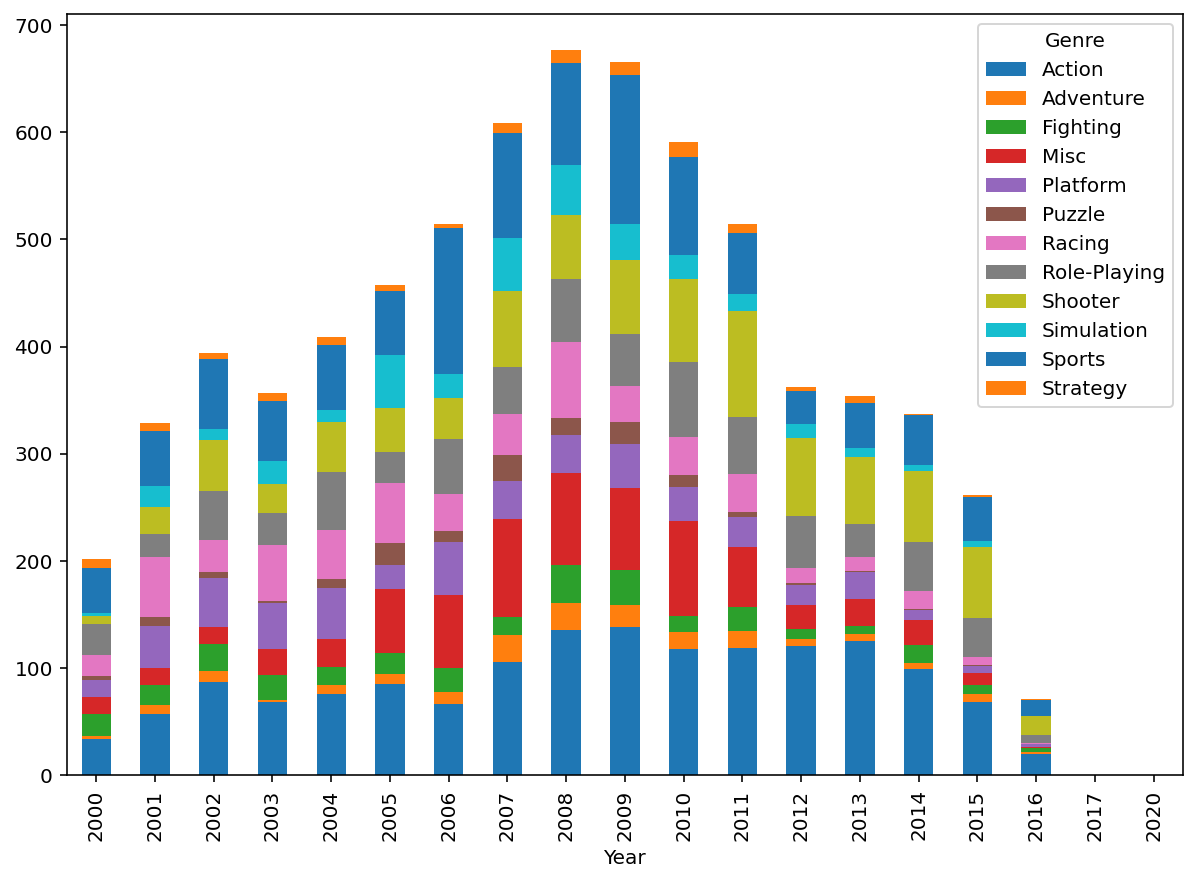

In [79]:
#연도별 장르 추이
df2 = df_G.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis = 1)
df_Y = pd.DataFrame(df2.groupby(['Year','Genre'])['Total_Sales'].sum().sort_values(ascending = False).reset_index())
df_P = df_Y.pivot(index = 'Year',columns = 'Genre', values = 'Total_Sales')
df_P.plot.bar(stacked=True, figsize=(10,7))

전반적인 하락 추세지만 Action은 꾸준히 인기가 많고, sports는 하락추세임. shooter가 좋은 성적을 내고 있음.

2008년도에 매출이 좋았던 ip를 활용하여 인기 있는 장르의 게임을 제작하는 방향으로 준비.

# 지역, 연도별 선호 장르를 기준으로 게임 장르 및 판매 지역 선정
지역별 선호 장르\
NA,EU,Other - Action, Sports, Shooter \
JP - Role-Playing, Action, sports\
출고량은 Action, Sports, Shooter, Misc 순으로 높음.

연도별 선호 장르는
Action, Sports, Shooter 3 장르가 꾸준히 인기가 많으나 Sports 장르는 감소하는 추세임.

지역은 NA,EU을 타겟으로 선정하고, 장르는 Action, Shooter 두가지 장르로 준비\
전체 지역에 판매가 잘되는 Action을 1순위 Shooter는 2순위

#3.출고량이 높은 게임에 대한 분석 및 시각화 프로세스

게임의 호황기였던 2007년부터 꾸준히 인기가 있는 ip를 찾아보기로 함.

In [98]:
#호황기였던 2007년 이후로 꾸준히 인기가 있는 ip 찾기.
df_ip = df.loc[(df.Year >= 2007)] #2007년 이후
df_ip2 = df_ip.loc[(df_ip.Genre == 'Action')|(df_ip.Genre == 'Shooter')]\
          .sort_values(by='Total_Sales', ascending = False)  #Action, Shooter 장르 내에서 찾는것으로 한정
df_ip2.sort_values(by='Total_Sales', ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
6236,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
9924,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73


## 출고량이 가장 높은 Grand Theft Auto와 달리
##Call of Duty 시리즈가 상위권을 차지한것이 눈에띔.
출고량이 높은 Action 장르가 상위권을 대다수 차지 할 것으로 예상하였으나 예상밖의 결과


###3-1 Action장르에 2007년 부터의 성적 확인

In [121]:
df_Action  = df_ip.loc[(df_ip.Genre == 'Action')]\
          .sort_values(by='Total_Sales', ascending = False)

df_Action.loc[(df_Action.Year >= 2007)].sort_values(by='Total_Sales', ascending = False).head(15)
# 출고량 상위 6개이외에 판매량이 급격히 떨어지는것이 보여짐.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2008,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
4806,Pokemon HeartGold/Pokemon SoulSilver,DS,2009,Action,Nintendo,4.40,2.77,3.96,0.77,11.90
13926,Grand Theft Auto IV,X360,2008,Action,Take-Two Interactive,6.76,3.10,0.14,1.03,11.03
16475,Grand Theft Auto IV,PS3,2008,Action,Take-Two Interactive,4.76,3.76,0.44,1.62,10.58
9035,FIFA Soccer 13,PS3,2012,Action,Electronic Arts,1.06,5.05,0.13,2.01,8.25
11868,Uncharted 3: Drake's Deception,PS3,2011,Action,Sony Computer Entertainment,2.77,2.80,0.19,1.06,6.82
13552,Uncharted 2: Among Thieves,PS3,2009,Action,Sony Computer Entertainment,3.27,2.25,0.21,1.00,6.73
16276,Red Dead Redemption,PS3,2010,Action,Take-Two Interactive,2.79,2.61,0.17,1.03,6.60


In [123]:
df_Action.shape  #Action는 게임의 출시량이 많아서 출고량이 높은 것이고, 전체적인 판매량은 좋지 못한 것으로 확인됨. 즉 레드오션

(2134, 10)

###3-2 Shooter 장르의 2007년부터의 성적 확인

In [122]:
df_Shooter = df_ip.loc[(df_ip.Genre == 'Shooter')]\
          .sort_values(by='Total_Sales', ascending = False)

df_Shooter.loc[(df_Shooter.Year >= 2007)].sort_values(by='Total_Sales', ascending = False).head(15)

#Action장르에 비해 10M이상의 성적을 준수하게 잘냄.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
6236,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
9924,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73
6291,Halo 3,X360,2007,Shooter,Microsoft Game Studios,7.97,2.83,0.13,1.21,12.14
8374,Call of Duty: Modern Warfare 2,PS3,2009,Shooter,Activision,4.99,3.69,0.38,1.63,10.69


In [124]:
df_Shooter.shape #Shooter장르는 Action 장르에 비해 시장이 크지 않으나 출시된 게임들이 준수한 성적을 내는 것으로 판단됨.

(653, 10)

#4. 퍼블리셔 선정

Action장르를 진행할 경우 퍼블리셔는 출고량이 가장 높았던 Take-Two Interactive 퍼블리셔의 성적을 보겠습니다.

In [126]:
df_Take = df_ip.loc[df_ip.Publisher.str.contains('Take-Two Interactive')].sort_values(by='Total_Sales', ascending = False)
df_Take.loc[(df_Take.Genre == 'Action')].head(10)

#Grand Theft Auto V 성공 외에는 전체적으로 낮은 출고량을 보여줌.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2008,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
13926,Grand Theft Auto IV,X360,2008,Action,Take-Two Interactive,6.76,3.10,0.14,1.03,11.03
16475,Grand Theft Auto IV,PS3,2008,Action,Take-Two Interactive,4.76,3.76,0.44,1.62,10.58
16276,Red Dead Redemption,PS3,2010,Action,Take-Two Interactive,2.79,2.61,0.17,1.03,6.60
10131,Red Dead Redemption,X360,2010,Action,Take-Two Interactive,3.70,1.97,0.09,0.57,6.33
10834,Grand Theft Auto V,XOne,2014,Action,Take-Two Interactive,2.66,2.01,0.00,0.41,5.08
13795,Ghostbusters: The Video Game (DS Version),X360,2009,Action,Take-Two Interactive,1.04,1.24,0.03,0.27,2.58
12819,NBA 2K11,X360,2010,Action,Take-Two Interactive,1.84,0.12,0.01,0.13,2.10


Shooter장르를 진행할 경우 퍼블리셔는 출고량이 가장 높았던 Activision으로 선정하여 성적을 보겠습니다.

In [129]:
#장르는 Shooter 로 publisher Activision가 안정적인지 확인.

df_Activision = df_ip.loc[df_ip.Publisher.str.contains('Activision')]\
                          .sort_values(by='Total_Sales', ascending = False)
df_Activision.loc[(df_Activision.Genre == 'Shooter')].head(10)

# Call of Duty 시리즈로 제작시 상위권에 안착하기 쉽다는걸 확인함.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
6236,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
9924,Call of Duty: Black Ops,PS3,2010,Shooter,Activision,5.98,4.44,0.48,1.83,12.73
8374,Call of Duty: Modern Warfare 2,PS3,2009,Shooter,Activision,4.99,3.69,0.38,1.63,10.69
5604,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.72,2.63,0.04,0.82,10.21


두 퍼블리셔간의 출고량을 비교 분석

In [133]:
#Action
df_Action_All = df_Action.drop(['Name','Platform','Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis = 1).reset_index(drop=True)
df_A = df_Action_All.groupby(['Year']).sum().reset_index()\
                             .rename(columns={'Total_Sales':'Action'})

#Take-Two 연도별 출고량
df_Take0 = df_Action_All.loc[df_Action_All.Publisher == ('Take-Two Interactive')]
df_TT = df_Take0.groupby(['Year']).sum().reset_index()\
                    .rename(columns={'Total_Sales':'Take-Two Interactive'})

In [134]:
#shooter
df_Shooter_All = df_Shooter.drop(['Name','Platform','Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis = 1).reset_index(drop=True)
df_S = df_Shooter_All.groupby(['Year']).sum().reset_index()
#Activision 연도별 출고량
df_Act0 = df_Shooter_All.loc[df_Shooter_All.Publisher == ('Activision')]
df_Act = df_Act0.groupby(['Year']).sum().reset_index()\
                    .rename(columns={'Total_Sales':'Activision'})


#merge Take-Two , Activision 두 데이터 합치기

df_AT = df_TT.merge(df_Act, how = 'inner', on= 'Year')
df_AT.describe()

,Year,Take-Two Interactive,Activision
count,8.000000,8.000000,8.000000
mean,2010.875000,14.845000,28.561250
std,2.900123,14.247335,5.717895
min,2007.000000,0.480000,18.860000
25%,2008.750000,3.015000,26.795000
50%,2010.500000,11.220000,30.390000
75%,2013.250000,26.482500,32.210000
max,2015.000000,37.770000,34.570000


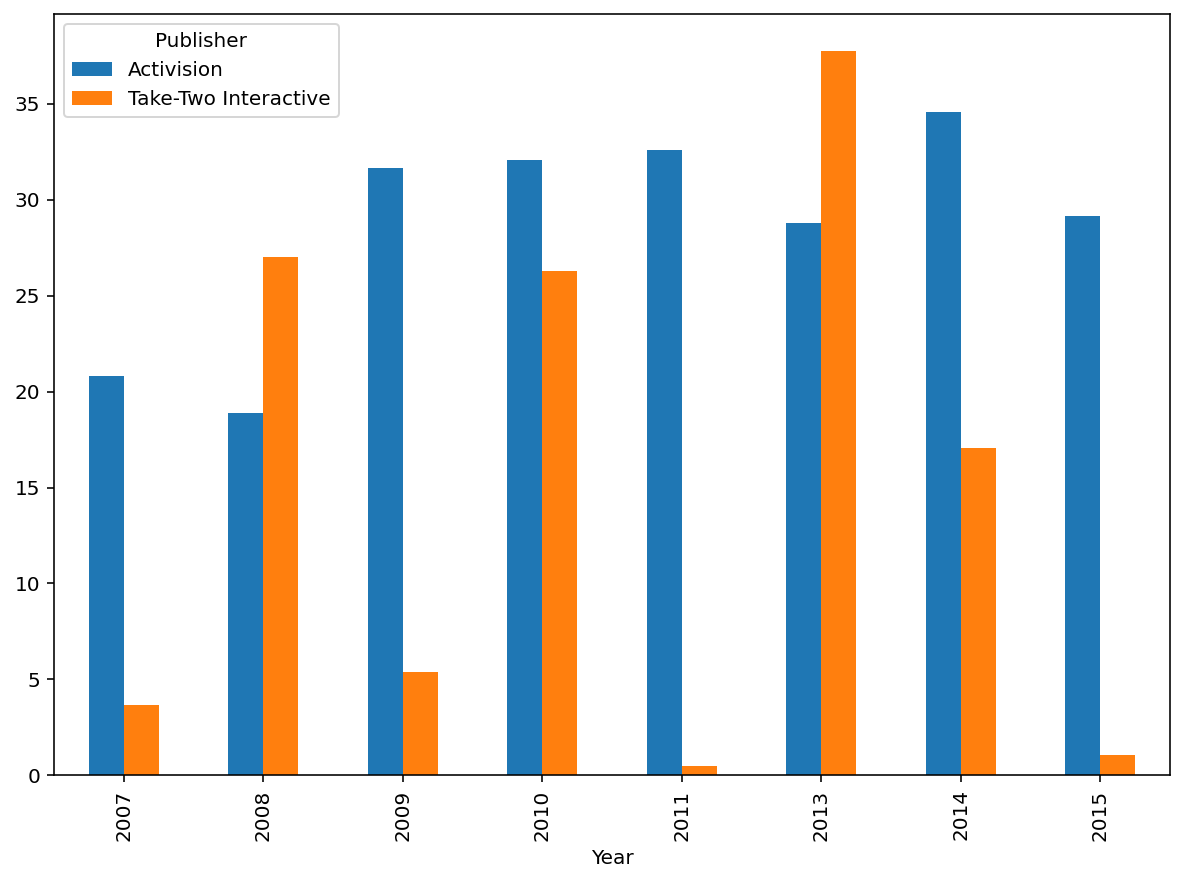

In [135]:
#data 시각화
id_var = ["Year"]
df_tidy2 = pd.melt(df_AT,id_vars=id_var ,var_name = "Publisher", value_name="Sales")

df_P2 = df_tidy2.pivot(index = 'Year',columns = 'Publisher', values = 'Sales')
df_P2.loc[:,['Activision', 'Take-Two Interactive']].plot.bar(figsize=(10,7))

Shooter장르의 Activision은 꾸준한 판매량을 보이고 있고,
Action 장르의 Take-two Interactive는 판매량이 일정하지 않음.

Shooter 장르로 publisher는 Activision으로 준비하는 것이 좋을 것으로 예상됨.

# 5. Activision의 Shooter 장르 출고 비율 확인

In [115]:
df_last = df_AT.merge(df_S, how = 'inner', on= 'Year')

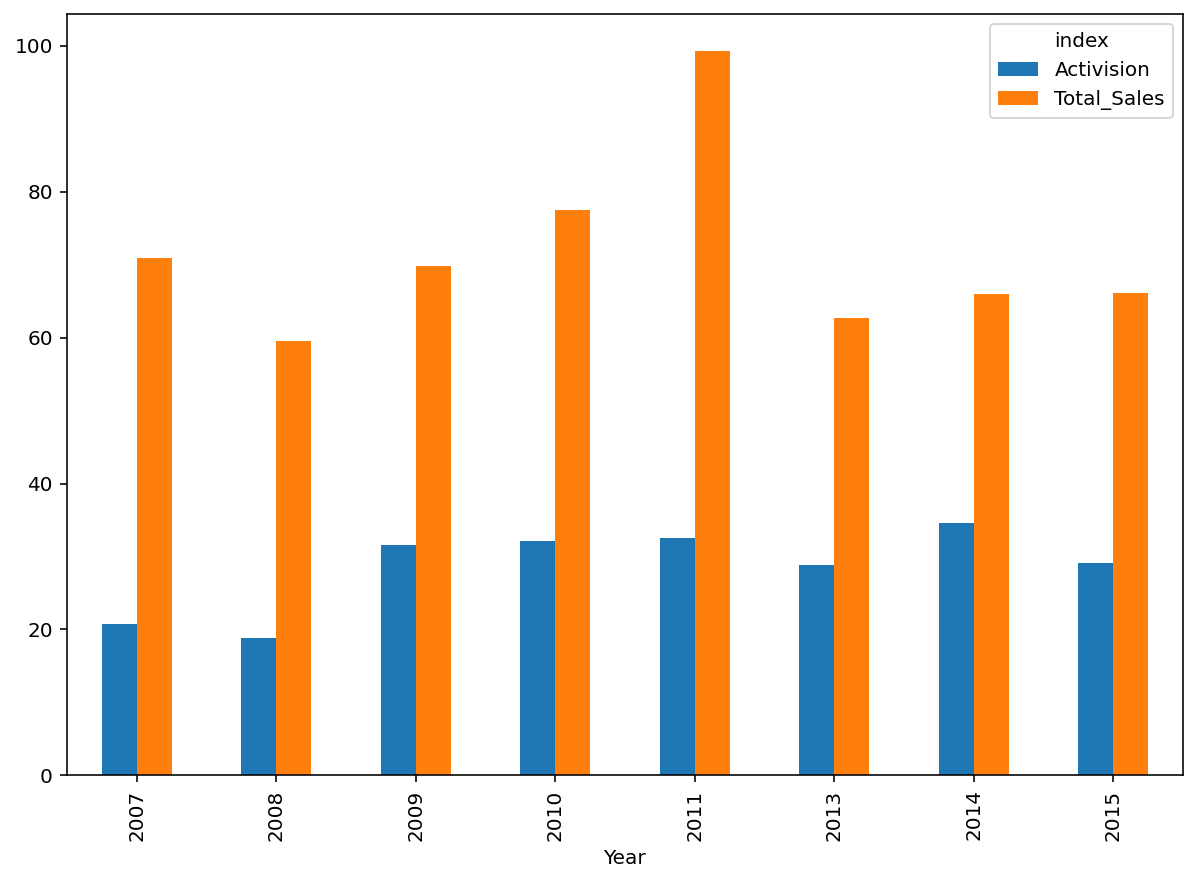

In [136]:
#data Tidy화
id_var = ["Year"]
df_tidy3 = pd.melt(df_last,id_vars=id_var ,var_name = "index", value_name="Sales")
#시각화
df_P3 = df_tidy3.pivot(index = 'Year',columns = 'index', values = 'Sales')
df_P3.loc[:,['Activision', 'Total_Sales']].plot.bar(figsize=(10,7))

표와 같이 Shooter장르내에서 Activision은 많은 지분을 차지하고 있는것으로 보여짐.

# 6. 플랫폼 선정

In [137]:
# Call of Duty 시리즈만 데이터남기기

df_Call = df_Activision.loc[df_Activision.Name.str.contains("Call of Duty")]\
                            .sort_values(by='Year', ascending = False)
df_Call.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3465,Call of Duty: Modern Warfare Trilogy,PS3,2016,Shooter,Activision,0.00,0.01,0.00,0.00,0.01
2795,Call of Duty: Modern Warfare Trilogy,X360,2016,Shooter,Activision,0.01,0.01,0.00,0.00,0.02
15981,Call of Duty: Black Ops 3,XOne,2015,Shooter,Activision,4.52,2.09,0.01,0.67,7.29
11892,Call of Duty: Black Ops 3,PC,2015,Shooter,Activision,0.00,0.22,0.00,0.01,0.23
12266,Call of Duty: Black Ops 3,X360,2015,Shooter,Activision,1.11,0.48,0.00,0.16,1.75


In [139]:
#플랫폼 데이터화
df_call = pd.DataFrame(df_Call.groupby(['Year','Platform']).sum()).reset_index()
df_call = df_call.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis = 1)
df_call.head()

,Year,Platform,Total_Sales
0,2007,DS,1.07
1,2007,PC,1.15
2,2007,PS3,6.72
3,2007,PSP,2.14
4,2007,X360,9.32


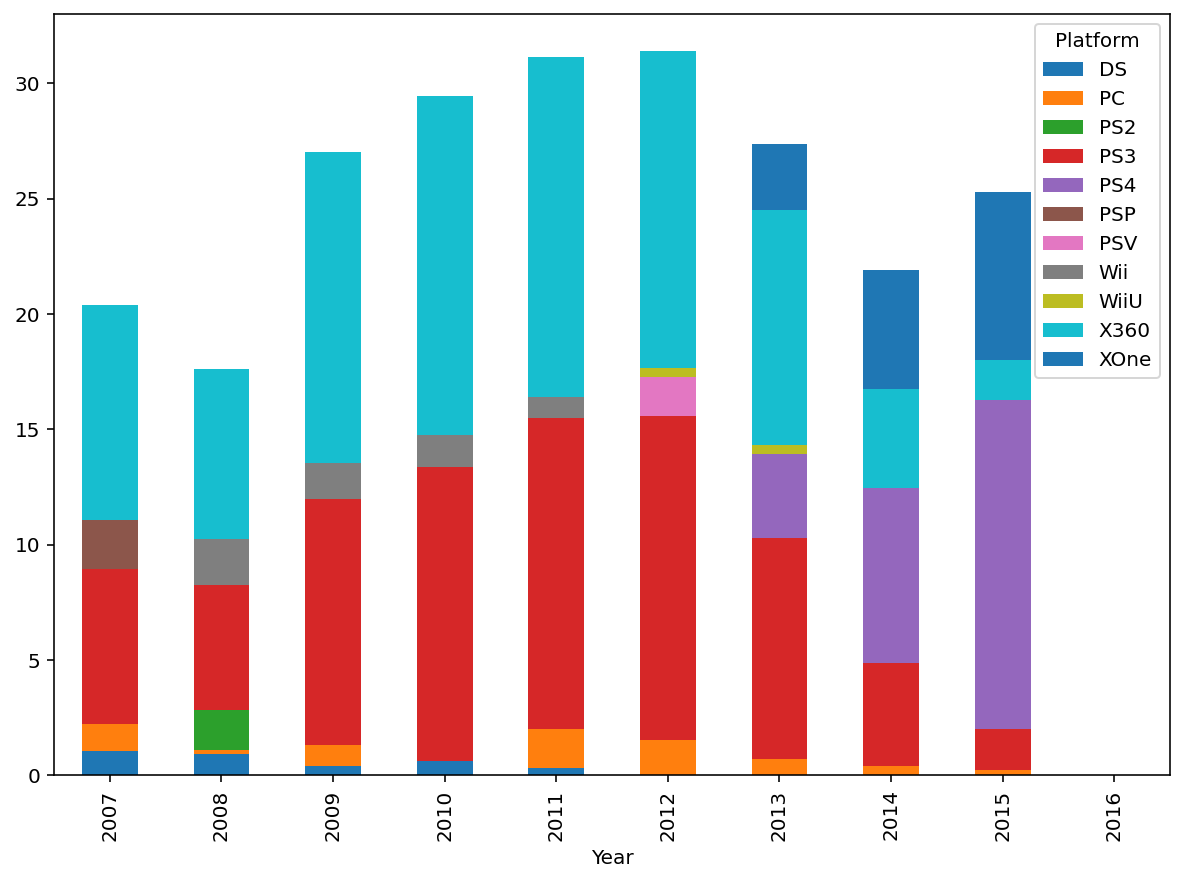

In [140]:
df_platform = df_call.pivot(index = 'Year', columns= 'Platform', values= 'Total_Sales')
df_platform.plot.bar(stacked=True, figsize=(10,7))

플랫폼 기종은 신규 기종이 나오면 플랫폼 시장 자리를 금방 내주게되는 점을 미뤄
Xone과 PSV를 타겟으로 공략 진행

#결론
지역타겟 : NA,EU\
장르     : Shooter\
사용 ip  : Call of Duty\
퍼블리셔 : Activision\
플랫폼   : PS V, X One